===== 子图切分结果 =====
Device cuda 包含节点:
  - prim::Constant_0: prim::Constant
  - aten::to_18: aten::to
  - aten::linear_19: aten::linear
  共 20 个节点


===== 性能对比 =====
原生执行: 2.3627s
异构执行: 2.3958s
加速比: 0.99x

设备时间分布图已保存为 device_time.png


STAGE:2025-05-11 16:27:52 1493:1493 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-05-11 16:27:52 1493:1493 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-05-11 16:27:52 1493:1493 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


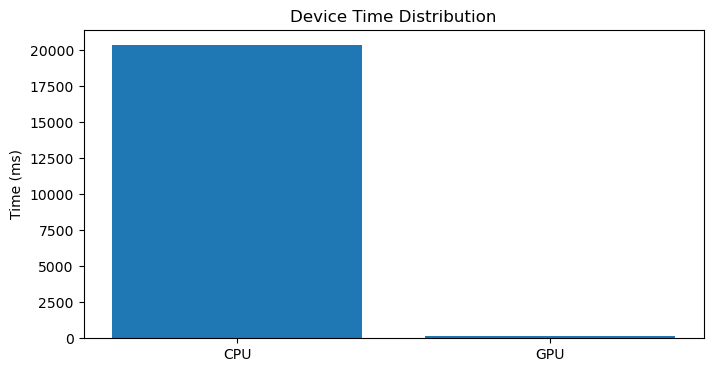

In [2]:

import torch
import torch.nn as nn
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function
import time

# ==================== 1. 配置参数 ====================
class Config:
    seq_length = 50      # 输入序列长度
    input_size = 128      # 输入特征维度
    hidden_size = 512     # LSTM隐藏层维度
    num_layers = 2        # LSTM层数
    batch_size = 32       # 批大小
    device_preference = { # 算子设备分配策略
        'lstm': 'cpu',    # LSTM放在CPU
        'linear': 'cuda'  # 线性层放在GPU
    }

# ==================== 2. 构造LSTM模型 ====================
class HeteroLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        # 确保各层在创建时就分配到正确设备
        self.lstm = nn.LSTM(
            input_size=Config.input_size,
            hidden_size=Config.hidden_size,
            num_layers=Config.num_layers,
            batch_first=True
        ).to(Config.device_preference['lstm'])
        
        self.fc = nn.Linear(
            Config.hidden_size, 
            Config.input_size
        ).to(Config.device_preference['linear'])
        
    def forward(self, x):
        # 确保输入在LSTM设备上
        device = next(self.lstm.parameters()).device
        x = x.to(device)
        
        # 初始化隐藏状态（与LSTM同设备）
        h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(device)
        c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(device)
        
        # LSTM计算
        out, _ = self.lstm(x, (h0, c0))
        
        # 转换到线性层设备
        out = out.to(next(self.fc.parameters()).device)
        return self.fc(out)

# ==================== 3. 自动切分器 ====================
class LSTMSplitter:
    def __init__(self):
        self.comm_cost = 0.5  # 跨设备通信成本系数
        
    def build_graph(self, model, example_input):
        # 使用TorchScript获取计算图
        with torch.no_grad():
            traced = torch.jit.trace(model, example_input)
            graph = traced.graph_for(example_input)
        
        # 构建NetworkX计算图
        G = nx.DiGraph()
        node_mapping = {}
        
        for node in graph.nodes():
            if node.kind() == 'prim::GetAttr':
                continue
                
            node_name = f"{node.kind()}_{len(node_mapping)}"
            node_mapping[node] = node_name
            
            # 确定设备偏好
            device = 'cuda'  # 默认
            for op_type, pref in Config.device_preference.items():
                if op_type in node.kind().lower():
                    device = pref
                    break
            
            G.add_node(node_name, 
                      op_type=node.kind(),
                      device=device)
        
        # 添加边
        for node in graph.nodes():
            if node not in node_mapping:
                continue
                
            for inp in node.inputs():
                if inp.node() in node_mapping:
                    G.add_edge(node_mapping[inp.node()], node_mapping[node])
        
        return G

    def split_graph(self, G):
        """基于设备偏好的子图切分"""
        partitions = defaultdict(list)
        visited = set()
        
        def dfs(node, current_partition, target_device):
            if node in visited:
                return
                
            # 检查设备切换成本
            node_device = G.nodes[node]['device']
            if node_device != target_device:
                # 简单估算：如果通信成本 > 计算成本/3 则留在原分区
                compute_cost = 1.0  # 简化估算
                if self.comm_cost > compute_cost / 3:
                    node_device = target_device
            
            if node_device == target_device:
                visited.add(node)
                current_partition.append(node)
                for successor in G.successors(node):
                    dfs(successor, current_partition, target_device)
        
        # 按拓扑排序处理
        for node in nx.topological_sort(G):
            if node not in visited:
                target_device = G.nodes[node]['device']
                current_partition = []
                dfs(node, current_partition, target_device)
                partitions[target_device].extend(current_partition)
        
        return partitions

# ==================== 4. 异构执行引擎 ====================
class HeteroExecutor:
    def __init__(self, model):
        self.model = model
        self.splitter = LSTMSplitter()
        self.partitions = None
        self.stream = torch.cuda.Stream() if torch.cuda.is_available() else None
    
    def prepare(self, example_input):
        """预编译并切分计算图"""
        G = self.splitter.build_graph(self.model, example_input)
        self.partitions = self.splitter.split_graph(G)
        
        # 打印切分结果
        print("===== 子图切分结果 =====")
        for device, nodes in self.partitions.items():
            print(f"Device {device} 包含节点:")
            for node in nodes[:3]:  # 只打印前3个节点示例
                print(f"  - {node}: {G.nodes[node]['op_type']}")
            print(f"  共 {len(nodes)} 个节点\n")
    
    def execute(self, x):
        """执行异构计算"""
        # LSTM部分在CPU
        lstm_device = next(self.model.lstm.parameters()).device
        x_cpu = x.to(lstm_device, non_blocking=True)
        h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(lstm_device)
        c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(lstm_device)
        lstm_out, _ = self.model.lstm(x_cpu, (h0, c0))
        
        # 线性层在GPU
        if self.stream:
            with torch.cuda.stream(self.stream):
                fc_device = next(self.model.fc.parameters()).device
                lstm_out_gpu = lstm_out.to(fc_device, non_blocking=True)
                output = self.model.fc(lstm_out_gpu)
        else:
            fc_device = next(self.model.fc.parameters()).device
            lstm_out_gpu = lstm_out.to(fc_device)
            output = self.model.fc(lstm_out_gpu)
        
        if self.stream:
            torch.cuda.synchronize()
        return output

# ==================== 5. 性能分析工具 ====================
def benchmark(model, input_tensor, rounds=100):
    # 原生执行
    start = time.time()
    for _ in range(rounds):
        model(input_tensor)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    native_time = time.time() - start
    
    # 异构执行
    executor = HeteroExecutor(model)
    executor.prepare(input_tensor)
    
    start = time.time()
    for _ in range(rounds):
        executor.execute(input_tensor)
    hetero_time = time.time() - start
    
    # 结果
    print(f"\n===== 性能对比 =====\n"
          f"原生执行: {native_time:.4f}s\n"
          f"异构执行: {hetero_time:.4f}s\n"
          f"加速比: {native_time/hetero_time:.2f}x")

# ==================== 6. 可视化设备时间分布 ====================
def profile_device_time(model, input_tensor):
    executor = HeteroExecutor(model)
    
    with profile(activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ], record_shapes=True) as prof:
        with record_function("hetero_execution"):
            executor.execute(input_tensor)
    
    # 分析结果
    device_times = {'CPU': 0, 'GPU': 0}
    for event in prof.events():
        if 'lstm' in event.name.lower():
            device_times['CPU'] += event.cpu_time
        elif 'linear' in event.name.lower():
            device_times['GPU'] += event.cuda_time
    
    # 绘图
    plt.figure(figsize=(8, 4))
    plt.bar(device_times.keys(), device_times.values())
    plt.title("Device Time Distribution")
    plt.ylabel("Time (ms)")
    plt.savefig("device_time.png")
    print("\n设备时间分布图已保存为 device_time.png")

# ==================== 7. 主执行流程 ====================
if __name__ == "__main__":
    # 检查设备可用性
    if not torch.cuda.is_available():
        Config.device_preference['linear'] = 'cpu'
        print("警告: CUDA不可用，所有计算将在CPU执行")
    
    # 构造随机输入数据
    input_data = torch.randn(
        Config.batch_size, 
        Config.seq_length, 
        Config.input_size
    )
    
    # 初始化模型
    model = HeteroLSTM()
    
    # 性能测试
    benchmark(model, input_data)
    
    # 性能分析
    if torch.cuda.is_available():
        profile_device_time(model, input_data)
    else:
        print("CUDA不可用，跳过GPU性能分析")